In [48]:
import pandas as pd
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt

# Year column operations

In [9]:
n = 10 * 10**6
choices = [str(i) for i in range(2021, 2025)]


In [61]:
col2 = col1.astype(np.int16)
print(f"{col2.memory_usage(deep=True)/1024**2} MB")


19.073612213134766 MB


In [62]:
col3 = col1.astype("category")
print(f"{col3.memory_usage(deep=True)/1024**2} MB")

9.53726577758789 MB


# Yearmon column operations

Sometimes we have data where dates are given as a yearmon (year + month) column  

In [10]:
choices = [str(i) for i in range(2021, 2025)]
choices = [i + str(j).zfill(2) for i in choices for j in range(1,13)]



In [11]:
def create_frame(n=10**3, seed=1):
    rng = np.random.default_rng(seed=seed)
    col1 = pd.Series(rng.choice(choices, n)).astype(str)
    df = pd.DataFrame(col1, columns=["yearmon_str"])
    df["yearmon_int64"] = df.yearmon_str.astype(np.int64)
    df["yearmon_int32"] = df.yearmon_str.astype(np.int32)
    df["yearmon_cat"] = df.yearmon_str.astype("category")
    return df

In [49]:
num_rows = [10**n for n in range(1,8)]
results = []

for n in num_rows:
    # perform experiment multiple times per setting
    for it in range(7):
        df = create_frame(n)
        method = "string"
        start_time = time.perf_counter()
        df["year_str"] = df.yearmon_str.str[:4]
        df["month_str"] = df.yearmon_str.str[4:]
        results.append({"row_number": n, "data_type": method,"run_time":time.perf_counter () - start_time})
        method = "cat"
        start_time = time.perf_counter()
        df["year_cat"] = df.yearmon_cat.str[:4]
        df["month_cat"] = df.yearmon_cat.str[4:]
        results.append({"row_number": n, "data_type": method,"run_time":time.perf_counter () - start_time})
        
        method = "int64"
        start_time = time.perf_counter()
        df["year_int64"] = df.yearmon_int64 // 100 
        df["month_int64"] = df.yearmon_int64 - df.year_int64*100
        results.append({"row_number": n, "data_type": method,"run_time":time.perf_counter () - start_time})

        method = "int32"
        start_time = time.perf_counter()
        df["year_int32"] = df.yearmon_int32 // 100 
        df["month_int32"] = df.yearmon_int32 - df.year_int32*100
        results.append({"row_number": n, "data_type": method,"run_time":time.perf_counter () - start_time})
        # If one needs to save memory even more then the following method might be useful
        # method= "int16_and_int8"
        # start_time = time.perf_counter()
        # df["year_int16"] = df.yearmon_int32 // 100
        # df.year_int16 = df.year_int16.astype(np.int16)
        # df["month_int8"] = df.yearmon_int32 - df.year_int16 * 100
        # df.month_int8 = df.month_int8.astype(np.int8)
        
        results.append({"row_number": n, "data_type": method,"run_time":time.perf_counter () - start_time})

results = pd.DataFrame(results)

results = results.groupby(by = ["row_number", "data_type"]).agg({"run_time":"mean"}).reset_index()
#results.run_time = results.run_time* 10**3# go to milli seconds from seconds
best_df = results.groupby(by="row_number").agg({"run_time":"min"}).reset_index()
results = pd.merge(results,
                   best_df,
                   how="left",
                   on = "row_number")
results.rename({"run_time_x":"run_time", "run_time_y":"best_run_time"}, axis=1, inplace=True)
results["times_best"] = results.run_time / results.best_run_time
results.head()

,row_number,data_type,run_time,best_run_time,times_best
0,10,cat,0.000565,0.000495,1.140987
1,10,int32,0.000602,0.000495,1.215445
2,10,int64,0.000624,0.000495,1.260461
3,10,string,0.000495,0.000495,1.000000
4,100,cat,0.000542,0.000503,1.076028


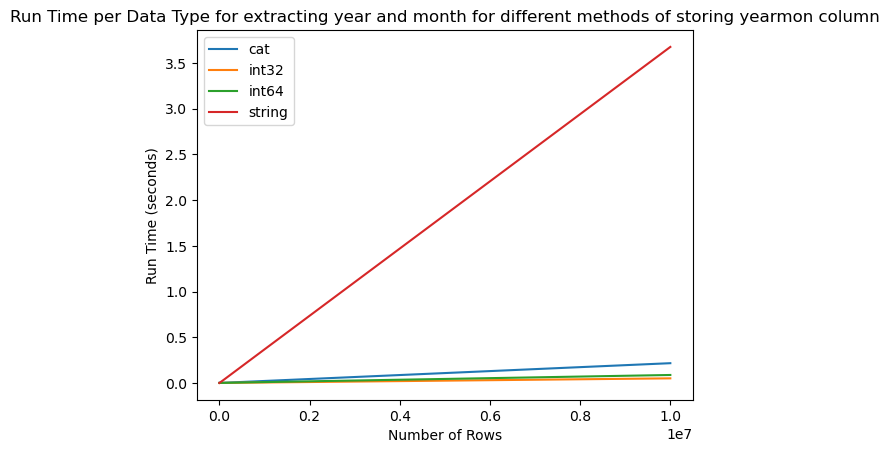

In [184]:
for data_type, group in results.groupby(by='data_type'):
    plt.plot(group['row_number'], group['run_time'], label=data_type)
plt.xlabel('Number of Rows')
plt.ylabel('Run Time (seconds)')
plt.title('Run Time per Data Type for extracting year and month for different methods of storing yearmon column')
plt.legend()
plt.show()

In [61]:

results.pivot(index="row_number",columns="data_type", values="times_best")

data_type,cat,int32,int64,string
row_number,,,,
10,1.140987,1.215445,1.260461,1.000000
100,1.076028,1.079150,1.063172,1.000000
1000,1.101413,1.050222,1.000000,1.572352
10000,1.326879,1.000000,1.041834,7.237515
100000,3.170596,1.000000,1.521377,46.749778
1000000,4.231640,1.000000,1.862093,70.404084
10000000,4.712210,1.000000,1.931945,79.483317


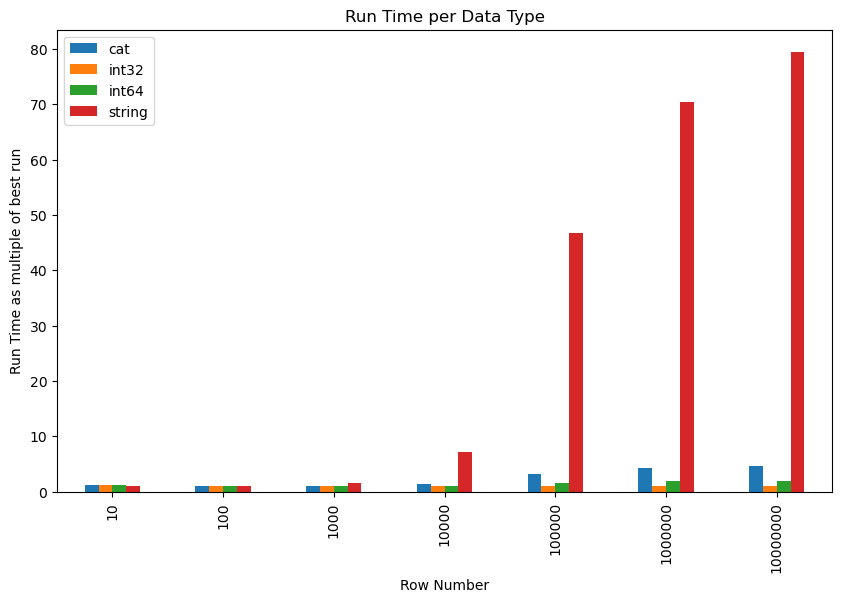

In [62]:
grouped_data = results.groupby(['row_number', 'data_type'])['times_best'].sum().reset_index()

# Pivot the grouped data to create a DataFrame suitable for stacked bar plot
pivot_df = grouped_data.pivot(index='row_number', columns='data_type', values='times_best').fillna(0)

# Create the stacked bar plot
pivot_df.plot(kind='bar', stacked=False, figsize=(10, 6))

# Add labels, title, and legend
plt.xlabel('Row Number')
plt.ylabel('Run Time as multiple of best run')
plt.title('Run Time per Data Type')
plt.legend()

# Show the plot
plt.show()

# Remaining experiments only started

In [72]:
n = 10000000
df = create_frame(n)
df["value"] = np.ones(n)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 5 columns):
 #   Column         Dtype   
---  ------         -----   
 0   yearmon_str    object  
 1   yearmon_int64  int64   
 2   yearmon_int32  int32   
 3   yearmon_cat    category
 4   value          float64 
dtypes: category(1), float64(1), int32(1), int64(1), object(1)
memory usage: 276.6+ MB


In [73]:
print(f"memory_usage in MB at {n:,} rows in the yearmon column")
df.memory_usage(deep=True, index=False)/1024**2

memory_usage in MB at 10,000,000 rows in the yearmon column


yearmon_str      600.814819
yearmon_int64     76.293945
yearmon_int32     38.146973
yearmon_cat        9.540649
value             76.293945
dtype: float64

In [64]:

%timeit df.groupby(by="yearmon_str").agg({"value":"sum"})
# For categorical values we usually need to set observed=True
%timeit df.groupby(by="yearmon_cat", observed=True).agg({"value":"sum"})
%timeit df.groupby(by="yearmon_int64").agg({"value":"sum"})
%timeit df.groupby(by="yearmon_int32").agg({"value":"sum"})

456 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
178 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
134 ms ± 695 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
127 ms ± 807 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
%%timeit
pd.merge(df.loc[:,["yearmon_str", "value"]], 
         df.loc[0:500,["yearmon_str", "value"]], 
         on = "yearmon_str", 
         how ="left")


6.18 s ± 59.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%timeit
pd.merge(df.loc[:,["yearmon_cat", "value"]], 
         df.loc[0:500,["yearmon_cat", "value"]], 
         on = "yearmon_cat", 
         how ="left")

4.31 s ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%%timeit
pd.merge(df.loc[:,["yearmon_int64", "value"]], 
         df.loc[0:500,["yearmon_int64", "value"]], 
         on = "yearmon_int64", 
         how ="left")

4.86 s ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit
pd.merge(df.loc[:,["yearmon_int32", "value"]], 
         df.loc[0:500,["yearmon_int32", "value"]], 
         on = "yearmon_int32", 
         how ="left")

4.68 s ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
%%timeit
pd.merge(df.loc[:,["yearmon_cat", "value"]].set_index("yearmon_cat", drop=True), 
         df.loc[0:500,["yearmon_cat", "value"]].set_index("yearmon_cat", drop=True), 
         left_index=True, right_index=True, 
         how ="left").reset_index()


4.54 s ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
%%timeit
pd.merge(df.loc[:,["yearmon_int32", "value"]].set_index("yearmon_int32", drop=True), 
         df.loc[0:500,["yearmon_int32", "value"]].set_index("yearmon_int32", drop=True), 
         left_index=True, right_index=True, 
         how ="left").reset_index()

4.9 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
